In [1]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.optimize import curve_fit

# Adjust path to import modules from src/
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.cosinor_model import CosinorModel
except ImportError:
    print("Error: CosinorModel module could not be loaded. Ensure paths are correct.")
    sys.exit(1)

In [3]:
# --- 2. Define Final Extracted Parameters and Load Data ---
FILTERED_FILE = '../data/filtered_data.csv'
RESULTS_DIR = '../results'
VALUE_COLUMN = 'Filtered_Value'

# NOTE: These values must be copied exactly from your successful main.py terminal output.
TAU_FFT = 24.0000 
M_FIT = 75.07
A_RAW = -5.04      
PHI_FIT_RAD = -2.162 # Raw phase in radians
ACROPHASE_CORRECTED = 12.34 
M_SE = 0.0223
A_SE = 0.0315

A_FINAL = np.abs(A_RAW)

try:
    filtered_df = pd.read_csv(FILTERED_FILE, index_col='Timestamp', parse_dates=True)
    Y_filtered = filtered_df[VALUE_COLUMN]
    print(f"Filtered data loaded successfully from: {FILTERED_FILE}")
except FileNotFoundError:
    print(f"Error: File {FILTERED_FILE} not found. Please run main.py first.")
    sys.exit(1)

Filtered data loaded successfully from: ../data/filtered_data.csv


In [5]:
# --- 3. Recalculate and Analyze Residuals ---

# Instantiate the CosinorModel and define time array (t in hours)
cosinor_instance = CosinorModel(tau=TAU_FFT)
start_time = filtered_df.index.min()
t_hours = (filtered_df.index - start_time).total_seconds() / 3600

# 3a. Generate fitted values using the RAW parameters
# The fit must be generated using the parameters returned by curve_fit
Y_fitted = cosinor_instance.cosinor_func(t_hours, M_FIT, A_RAW, PHI_FIT_RAD)

# 3b. Calculate Residuals (Actual Data - Fitted Model)
residuals = Y_filtered - Y_fitted

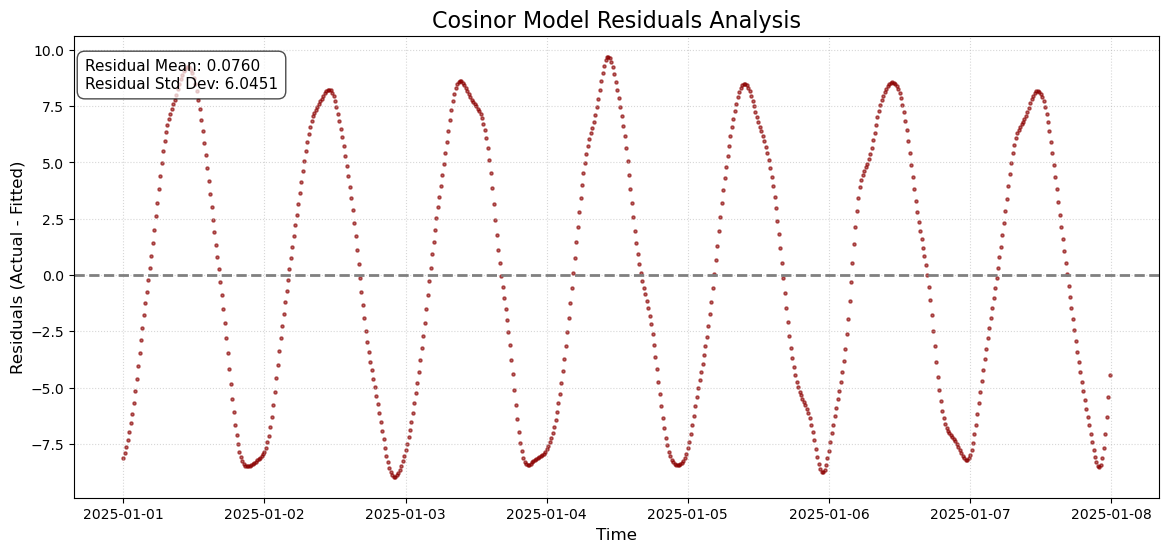

In [7]:
# --- 4. Plotting Residuals ---

plt.figure(figsize=(14, 6))

# Plot the residuals over time
plt.scatter(filtered_df.index, residuals, 
            label='Model Residuals', 
            s=5, alpha=0.6, color='darkred')

# Plot the zero line (where residuals should ideally cluster)
plt.axhline(0, color='gray', linestyle='--', linewidth=2)

# Calculate and display residual statistics
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

plt.text(0.01, 0.95, 
         f"Residual Mean: {mean_residual:.4f}\nResidual Std Dev: {std_residual:.4f}", 
         transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))

plt.title('Cosinor Model Residuals Analysis', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Residuals (Actual - Fitted)', fontsize=12)
plt.grid(axis='both', linestyle=':', alpha=0.5)

# Save the residual plot
os.makedirs(RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(RESULTS_DIR, 'model_residuals_plot.png'))
plt.show()

In [9]:
# --- 5. Displaying Statistical Confidence (Standard Errors) ---

print("\n--- Statistical Diagnostics ---")
print("Confidence in Parameter Estimation (Standard Errors)")
print("-" * 50)

# Display extracted parameters and their Standard Errors (SE)
results_summary = pd.DataFrame({
    'Parameter': ['Mesour (M)', 'Amplitude (A)', 'Acrophase (Hours)'],
    'Value': [M_FIT, A_FINAL, ACROPHASE_CORRECTED],
    'Std Error (SE)': [M_SE, A_SE, 'N/A*']
})

# Add a note explaining Acrophase SE calculation (since it's complex and not directly output)
print(results_summary.to_markdown(index=False, floatfmt=".4f"))
print("\n* Acrophase SE calculation is complex, involving A_SE, M_SE, and covariance.")
print("  Low SE values for M and A (relative to their magnitude) indicate high confidence in the fit.")


--- Statistical Diagnostics ---
Confidence in Parameter Estimation (Standard Errors)
--------------------------------------------------
| Parameter         |   Value | Std Error (SE)   |
|:------------------|--------:|:-----------------|
| Mesour (M)        | 75.0700 | 0.0223           |
| Amplitude (A)     |  5.0400 | 0.0315           |
| Acrophase (Hours) | 12.3400 | N/A*             |

* Acrophase SE calculation is complex, involving A_SE, M_SE, and covariance.
  Low SE values for M and A (relative to their magnitude) indicate high confidence in the fit.
